# InterVENE

This Jupyter Notebook presents InterVENE and can be run in a browser. For demonstration purposes, it is applied to the UCI Breast Cancer Wisconsin (Diagnostic) Data Set. Required dependencies:

* Python 3 and Jupyter
* PyTorch >= 0.40 (see https://pytorch.org/get-started/locally/)
* Matplotlib
* UMAP (see https://umap-learn.readthedocs.io/en/latest/)
* Sci-kit learn
* graphviz
* numpy
* random
* PMLB (for fetching the demo dataset, see https://github.com/EpistasisLab/penn-ml-benchmarks)

### Training the Neural Network

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import umap
from matplotlib.widgets import LassoSelector
from matplotlib.path import Path
from sklearn.tree import export_graphviz
from IPython.display import SVG, HTML, Image
from graphviz import Source
from IPython.display import display
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn import preprocessing
from sklearn.manifold import TSNE
import random
from pmlb import fetch_data, classification_dataset_names #To fetch a UCI dataset for demonstration purposes

In [2]:
# load data
data, labels = fetch_data('breast-cancer-wisconsin', return_X_y=True, local_cache_dir='./')
print("Dataset shape: ", data.shape, "labels shape: ", labels.shape)
x = preprocessing.scale(data)

feature_names = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean',
'symmetry_mean', 'fractal_dimension_mean',  'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 
'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']

print("Feature names: ", feature_names)
y = labels
y = y.astype(np.float32)
x = x.astype(np.float32)

x = torch.from_numpy(x).float()
y = torch.from_numpy(y)


Dataset shape:  (569, 30) labels shape:  (569,)
Feature names:  ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']


In [3]:
# Defining input size, hidden layer size, output size and batch size
#One network: save intermediate stages
epoch_list = [10,50,100]
layers = 2
num_epochs = epoch_list[-1]
n_h1=n_h2=20
n_out=1
n_in=x.shape[1]
weight_init=0.1
dropout=0.5

In [4]:
class Model(nn.Module):
    def __init__(self, n_in, n_h1, n_h2, n_out, weight_init, dropout):
        super(Model, self).__init__()
        self.dropout1 = nn.Dropout(p=dropout)
        self.firstlayer = nn.Linear(n_in, n_h1)
        self.relu1 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=dropout)
        self.secondlayer = nn.Linear(n_h1, n_h2)
        self.relu2 = nn.ReLU()
        self.dropout3 = nn.Dropout(p=dropout)
        self.thirdlayer = nn.Linear(n_h2, n_out)
        self.init_weights(weight_init)
        
    def init_weights(self, weight_init):
        """Initialize weights"""
        self.firstlayer.weight.data.normal_(0, weight_init) 
        self.secondlayer.weight.data.normal_(0, weight_init)
        self.thirdlayer.weight.data.normal_(0, weight_init)
        
    def forward(self, x):
        fl = self.relu1(self.firstlayer(self.dropout1(x)))
        sl = self.relu2(self.secondlayer(self.dropout2(fl)))
        output = self.thirdlayer(self.dropout3(sl))
        return fl, sl, torch.squeeze(output)

In [5]:
# Construct the loss function
criterion = torch.nn.BCEWithLogitsLoss()
outputs = dict()
losses=[]


epoch:  10  loss:  0.31138876080513
epoch:  50  loss:  0.12181776762008667
epoch:  100  loss:  0.12817542254924774


[0, 100, 0.0, 0.8]

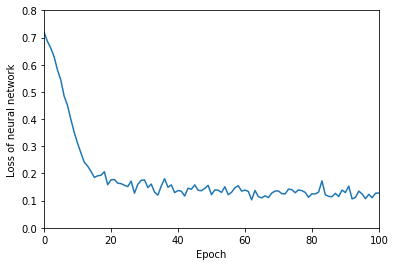

In [6]:
model = Model(n_in, n_h1, n_h2, n_out, weight_init, dropout)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
for epoch in range(num_epochs+1):
    
    y_pred = model(x)[-1]
    # Compute and print loss
    loss = criterion(y_pred, y)
    
    losses.append(loss)
    if epoch in epoch_list:
        print('epoch: ', epoch,' loss: ', loss.item())
        outputs[epoch]=model(x)[-1]
        torch.save(model.state_dict(), "model_public_%s_%s"%(str(layers), str(epoch)))
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()

    # perform a backward pass (backpropagation)
    loss.backward()

    # Update the parameters
    optimizer.step()
    
    
plt.plot(losses)
plt.ylabel("Loss of neural network")
plt.xlabel("Epoch")
plt.axis([0, epoch_list[-1], 0.0, 0.8])

In [7]:
model.load_state_dict(torch.load("model_public_%s_%s"%(2,100)))
model.eval()

results = model(x)

y_pred = results[-1]

loss = criterion(y_pred, y)
print("Loss: ", loss.item())
y_pred = y_pred.detach().numpy()
y_true = np.reshape(labels,(len(labels), ))

Loss:  0.061312347650527954


In [8]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
predictions=[]
print("Evaluation of Neural Network\n")
for p in y_pred:
    if p>0.5:
        predictions.append(1)
    else:
        predictions.append(0)
print("Confusion Matrix: \n", confusion_matrix(y_true, predictions),"\n")
print("Classification Report: \n",classification_report(y_true, predictions))

Evaluation of Neural Network

Confusion Matrix: 
 [[357   0]
 [ 11 201]] 

Classification Report: 
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       357
           1       1.00      0.95      0.97       212

   micro avg       0.98      0.98      0.98       569
   macro avg       0.99      0.97      0.98       569
weighted avg       0.98      0.98      0.98       569



### Visualization and Explanation

In [9]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as animation
#interactive plotting in separate window
%matplotlib qt 

In [10]:
# SETTINGS
SEED = 42
np.random.seed(SEED)

# set up constant variables
ALL = "all"
FALSE_POSITIVE = "false positive"
FALSE_NEGATIVE = "false negative" 
TRUE_POSITIVE = "true positive" 
TRUE_NEGATIVE = "true negative"
POSITIVE = "positive"
NEGATIVE = "negative" 
TRUE = "true"
FALSE = "false"
SLOW_ZOOMING_FACTOR = 1.1
NORMAL_COLOR = 'C7'
CLICKED_COLOR = 'C9'

In [11]:
# load data
torchlabels = torch.from_numpy(labels).view(len(labels),-1)
torchlabels = torchlabels.float()
dataset = x

In [12]:
def mscatter(x,y,ax=None, m=None, **kw):
    import matplotlib.markers as mmarkers
    if not ax: ax=plt.gca()
    sc = ax.scatter(x,y,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

In [13]:
from sklearn.tree._tree import TREE_LEAF

def is_leaf(inner_tree, index):
    # Check whether node is leaf node
    return (inner_tree.children_left[index] == TREE_LEAF and 
            inner_tree.children_right[index] == TREE_LEAF)

def prune_index(inner_tree, decisions, index=0):
    # Start pruning from the bottom - if we start from the top, we might miss
    # nodes that become leaves during pruning.
    # Do not use this directly - use prune_duplicate_leaves instead.
    if not is_leaf(inner_tree, inner_tree.children_left[index]):
        prune_index(inner_tree, decisions, inner_tree.children_left[index])
    if not is_leaf(inner_tree, inner_tree.children_right[index]):
        prune_index(inner_tree, decisions, inner_tree.children_right[index])

    # Prune children if both children are leaves now and make the same decision:     
    if (is_leaf(inner_tree, inner_tree.children_left[index]) and
        is_leaf(inner_tree, inner_tree.children_right[index]) and
        (decisions[index] == decisions[inner_tree.children_left[index]]) and 
        (decisions[index] == decisions[inner_tree.children_right[index]])):
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
        ##print("Pruned {}".format(index))

def prune_duplicate_leaves(mdl):
    # Remove leaves if both 
    decisions = mdl.tree_.value.argmax(axis=2).flatten().tolist() # Decision for each node
    prune_index(mdl.tree_, decisions)

In [14]:
# Set up scroll to zoom in and out for ax
def zoom_event(event,base_scale = SLOW_ZOOMING_FACTOR):
    # get the current x and y limits
    cur_xlim = ax.get_xlim()
    cur_ylim = ax.get_ylim()
    cur_xrange = (cur_xlim[1] - cur_xlim[0])*.5
    cur_yrange = (cur_ylim[1] - cur_ylim[0])*.5
    xdata = 0
    ydata = 0 
    if event.button == 'up':
        # deal with zoom in
        scale_factor = 1/base_scale
    elif event.button == 'down':
        # deal with zoom out
        scale_factor = base_scale
    else:
        # deal with something that should never happen
        scale_factor = 1
    # set new limits
    ax.set_xlim([xdata - cur_xrange*scale_factor,
                 xdata + cur_xrange*scale_factor])
    ax.set_ylim([ydata - cur_yrange*scale_factor,
                 ydata + cur_yrange*scale_factor])
    fig.canvas.draw_idle()

In [15]:
from matplotlib.widgets import Button

# Set up click event for ax
def accept_event(event):
    if event.key == "tab":
        global first_image_saved
        if not first_image_saved:
            save_first_cluster()
            first_image_saved=True
    elif event.key == "enter":
        if first_image_saved:
            save_second_cluster()

def filter_event(event):
    if event.button == 'bPositive':
        show_fragment(POSITIVE)
    else:
        print('button event: ', event.button)
# Control event functions
def save_first_cluster():
    selected = selector1.xys[selector1.ind]
    ax.set_title("Cluster 1", fontsize=50)
    fig.savefig("cluster1.SVG",bbox_inches='tight', pad_inches=0)
    selector1.disconnect()
    ax.set_title("Press ENTER to confirm second selection.",fontsize=20) 
    
    fig.canvas.draw()
    
def save_second_cluster():
    __counter__ = random.randint(0,2e9)
    cluster1 = selector1.ind
    cluster2 = selector2.ind
    selected = selector2.xys[cluster2]

    ax.set_title("Cluster 2", fontsize=50)
    fig.savefig("cluster2.SVG",bbox_inches='tight', pad_inches=0)
    selector2.disconnect()
    ax.set_title("")

    fig.canvas.draw()
    
    plt.close('all')
    
    bothclusters = np.concatenate((cluster1,cluster2))
    print("Cluster 1:", len(cluster1),"datapoints selected. Cluster 2:", len(cluster2),"datapoints selected.")
    
    x = dataset[bothclusters]
    y = []
    for value in cluster1:
        y.append("Cluster 1")
    for value in cluster2:
        y.append("Cluster 2")

#         print("Total number of selected points: ", len(y))
    y = np.asarray(y)
    idx = np.random.permutation(len(x))
    x,y = x[idx], y[idx]
    
    for c in fig1.get_children():  
        c.set_picker(True)
    fig1.canvas.mpl_connect('pick_event', onpick)
#     print("onpick")
    
    MAXDEPTH = 3

    dtc = tree.DecisionTreeClassifier(max_depth=MAXDEPTH, min_samples_leaf = 5, random_state=SEED)

    dtc = dtc.fit(x,y)
    prune_duplicate_leaves(dtc)
    ##############################################
    display(Image(filename='all_visualizations.png'))
    
    display(HTML("<table><tr><td><img src='cluster1.SVG?%d'></td><td><img src='cluster2.SVG?%d'></td></tr></table>"% (__counter__, __counter__)))
    graph = Source(export_graphviz(dtc, class_names=["Cluster 1", "Cluster 2"], impurity=False,feature_names=feature_names))
#     png_bytes = graph.pipe(format='pdf')
#     with open('dtree_pipe.pdf','wb') as f:
#         f.write(png_bytes)
    
    display(SVG(graph.pipe(format='svg')))
    pred = dtc.predict(x)

    # Compute accuracy based on test samples
    acc = accuracy_score(y, pred)
    print("Accuracy Decision Tree: ", acc)
    
    __counter__ = random.randint(0,2e9)
def show_all():
    [xs, ys] = tsneresults[selected]
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    prediction = predictions[selected]
    linewidths = [1 if k==1 else 4 for k in evaluations[selected]]
    m=['o' if k==1 else 'x' for k in evaluations[selected]]
    facecolors = [cmap(value) for value in prediction]
    
    ax.clear()

    pts = mscatter(xs, ys, c=prediction, vmin=0., vmax=1., s=200, cmap=cmap, m=m, ax=ax, linewidth=linewidths)
    pts.set_facecolor(facecolors)
    
    if first_image_saved:
        selector2.reset_collection(pts)
        ax.set_title("Press ENTER to confirm second selection.",fontsize=20)
    else:
        selector1.reset_collection(pts)
        ax.set_title("Showing all points. Press TAB to accept first selection",fontsize=20)

    
    ax.set_ylim(bottom=ybottom,top=ytop)
    ax.set_xlim(left=xleft,right=xright)
    [b_all,b_positive,b_negative,b_true,b_false,b_true_positive,b_true_negative,b_false_positive,b_false_negative] = set_up_filter_button()
    fig.canvas.draw_idle()
    
def show_fragment(tag, event=''):
    [xs, ys] = tsneresults[selected]
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    prediction = predictions[selected]
    linewidths = [1 if k==1 else 4 for k in evaluations[selected]]
    m=['o' if k==1 else 'x' for k in evaluations[selected]]

    tag_table = accuracy_table[selected]
    idxs = None
    if tag == POSITIVE:
        idxs = [idx for idx in range(len(tag_table)) if ((tag_table[idx] == FALSE_POSITIVE)or(tag_table[idx] == TRUE_POSITIVE))]
    elif tag == NEGATIVE:
        idxs = [idx for idx in range(len(tag_table)) if ((tag_table[idx] == FALSE_NEGATIVE)or(tag_table[idx] == TRUE_NEGATIVE))]
    elif tag == TRUE:
        idxs = [idx for idx in range(len(tag_table)) if ((tag_table[idx] == TRUE_POSITIVE)or(tag_table[idx] == TRUE_NEGATIVE))]
    elif tag == FALSE:
        idxs = [idx for idx in range(len(tag_table)) if ((tag_table[idx] == FALSE_POSITIVE)or(tag_table[idx] == FALSE_NEGATIVE))]
    else:
        idxs = [idx for idx in range(len(tag_table)) if tag_table[idx] == tag]

    if (idxs != None):
        xs = [xs[i] for i in idxs]
        ys = [ys[i] for i in idxs]
        prediction = [prediction[i] for i in idxs]
        linewidths = [linewidths[i] for i in idxs]
        markers = [m[i] for i in idxs]
    facecolors = [cmap(value) for value in prediction]

    ax.clear()
    if (len(xs) > 0):

        pts=mscatter(xs, ys, c=prediction, vmin=0., vmax=1., s=200, cmap=cmap, m=markers, ax=ax, linewidth=linewidths)
        pts.set_facecolor(facecolors)
        
        if first_image_saved:
            selector2.reset_collection(pts)
        else:
            selector1.reset_collection(pts)
    if first_image_saved:
        ax.set_title("Press ENTER to confirm second selection.",fontsize=20)
    else:

        ax.set_title("Showing %s points"%tag,fontsize=20)
    ax.set_ylim(bottom=ybottom,top=ytop)
    ax.set_xlim(left=xleft,right=xright)
    [b_all,b_positive,b_negative,b_true,b_false,b_true_positive,b_true_negative,b_false_positive,b_false_negative] = set_up_filter_button()

    fig.canvas.draw_idle()
    
def reset_threshold(new_threshold,event=''):
    threshold = new_threshold
    prediction = predictions[selected]
    new_accuracy_table = []
    new_decisions = []
    
    for p in prediction:
        if p<=threshold:
            new_decisions.append(0.)
        else:
            new_decisions.append(1.)
    
class FilterButton(object):
    def __init__(self,axes,name,tag):
        global current_tag
        if tag == current_tag:
            self.button = Button(axes,name,color=CLICKED_COLOR,hovercolor=CLICKED_COLOR)
        else:
            self.button = Button(axes,name,color=NORMAL_COLOR,hovercolor=NORMAL_COLOR)
        self.button.label.set_fontsize(14)
        self.button.on_clicked(self.process)
        self.tag = tag
        
    def process(self, event):
        reset_button_color()
        self.button.color = CLICKED_COLOR
        self.button.hovercolor = CLICKED_COLOR
        global current_tag
        current_tag = self.tag
        if self.tag == ALL:
            show_all()
        else:
            show_fragment(self.tag)

def reset_button_color():
    b_all.color = NORMAL_COLOR
    b_positive.color = NORMAL_COLOR
    b_negative.color = NORMAL_COLOR
    b_false.color = NORMAL_COLOR
    b_true.color = NORMAL_COLOR
    b_false_negative = NORMAL_COLOR
    b_false_positive = NORMAL_COLOR
    b_true_positive = NORMAL_COLOR
    b_true_negative = NORMAL_COLOR

def set_up_filter_button():
    axe_all = plt.axes([0.01, 0.09, 0.15, 0.035])
    
    axe_positive = plt.axes([0.01, 0.05, 0.15, 0.035])
    
    axe_negative = plt.axes([0.17, 0.05, 0.15, 0.035])
    
    axe_true = plt.axes([0.33, 0.05, 0.15, 0.035])
    
    axe_false = plt.axes([0.49, 0.05, 0.15, 0.035])
    
    axe_true_positive = plt.axes([0.01, 0.01, 0.15, 0.035])
    
    axe_true_negative = plt.axes([0.17, 0.01, 0.15, 0.035])
    
    axe_false_positive = plt.axes([0.33, 0.01, 0.15, 0.035])
    
    axe_false_negative = plt.axes([0.49, 0.01, 0.15, 0.035])
    
    b_all = FilterButton(axe_all, 'ALL',ALL)
    b_positive = FilterButton(axe_positive, 'POSITIVE',POSITIVE)
    b_negative = FilterButton(axe_negative, 'NEGATIVE',NEGATIVE)
    b_true = FilterButton(axe_true, 'TRUE',TRUE)
    b_false = FilterButton(axe_false, 'FALSE',FALSE)
    b_true_positive = FilterButton(axe_true_positive, 'TRUE POSITIVE',TRUE_POSITIVE)
    b_true_negative = FilterButton(axe_true_negative, 'TRUE NEGATIVE',TRUE_NEGATIVE)
    b_false_positive = FilterButton(axe_false_positive, 'FALSE POSITIVE',FALSE_POSITIVE)
    b_false_negative = FilterButton(axe_false_negative, 'FALSE NEGATIVE',FALSE_NEGATIVE)

    return [b_all,b_positive,b_negative,b_true,b_false,b_true_positive,b_true_negative,b_false_positive,b_false_negative]
    

In [16]:
### Set up click event to view a subplot
def onpick(event):
    if event.mouseevent.button != 1:
        return
    
    for picki in range(len(plts)):
        if event.artist == plts[picki]:
            print("Plot %s selected"%picki)
            subplotselector.ind = picki
            break
    
    global selected
    selected = subplotselector.ind

    [xs, ys] = tsneresults[selected]
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    subplot_kw = dict(xlim=(0, 30), ylim=(0, 30), autoscale_on=True)
    global fig, ax
    fig, ax = plt.subplots(subplot_kw=subplot_kw)
    # fig, ax = plt.subplots()
    points = np.zeros(len(xs))
    prediction = predictions[selected]
    facecolors = [cmap(value) for value in prediction]
    m=['o' if k==1 else 'x' for k in evaluations[selected]]
    linewidths = [1 if k==1 else 4 for k in evaluations[selected]]
    linewidth = evaluations[selected]
    normed_labels = norm(evaluations[selected])
    edgec = edgemap(normed_labels)
    global b_all,b_positive,b_negative,b_true,b_false,b_true_positive,b_true_negative,b_false_positive,b_false_negative
    [b_all,b_positive,b_negative,b_true,b_false,b_true_positive,b_true_negative,b_false_positive,b_false_negative] = set_up_filter_button()
    
    pts = mscatter(xs, ys, c=prediction, vmin=0., vmax=1., s=200, cmap=cmap, m=m, ax=ax, linewidth=linewidths)
    pts.set_facecolor(facecolors)

    clb = fig.colorbar(pts,ax=ax)
    clb.ax.get_yaxis().labelpad = 15

    clb.ax.set_ylabel('Prediction', rotation=270, fontsize=20)
    clb.ax.tick_params(labelsize=18)
    global selector1
    global selector2
    selector1 = SelectFromCollection(ax, pts)
    selector2 = SelectFromCollection(ax, pts)

    fig.canvas.mpl_connect("key_press_event", accept_event)
    fig.canvas.mpl_connect("scroll_event", zoom_event)

    ax.set_title("Select points (or press button) and press TAB to accept first selection.", fontsize=20)
    
    figManager = plt.get_current_fig_manager()
    figManager.window.showMaximized()
    global ybottom,ytop
    global xright, xleft
    ybottom,ytop = ax.get_ylim()
    xleft, xright = ax.get_xlim()

    plt.show()

Applying InterVENE to the UCI Breast Cancer Wisconsin (Diagnostic) Data Set, fetched from PMLB (https://github.com/EpistasisLab/penn-ml-benchmarks)
Loading plots for network trained for 10 epochs...
Loading plots for network trained for 50 epochs...
Loading plots for network trained for 100 epochs...
Plot 4 selected
Cluster 1: 358 datapoints selected. Cluster 2: 211 datapoints selected.


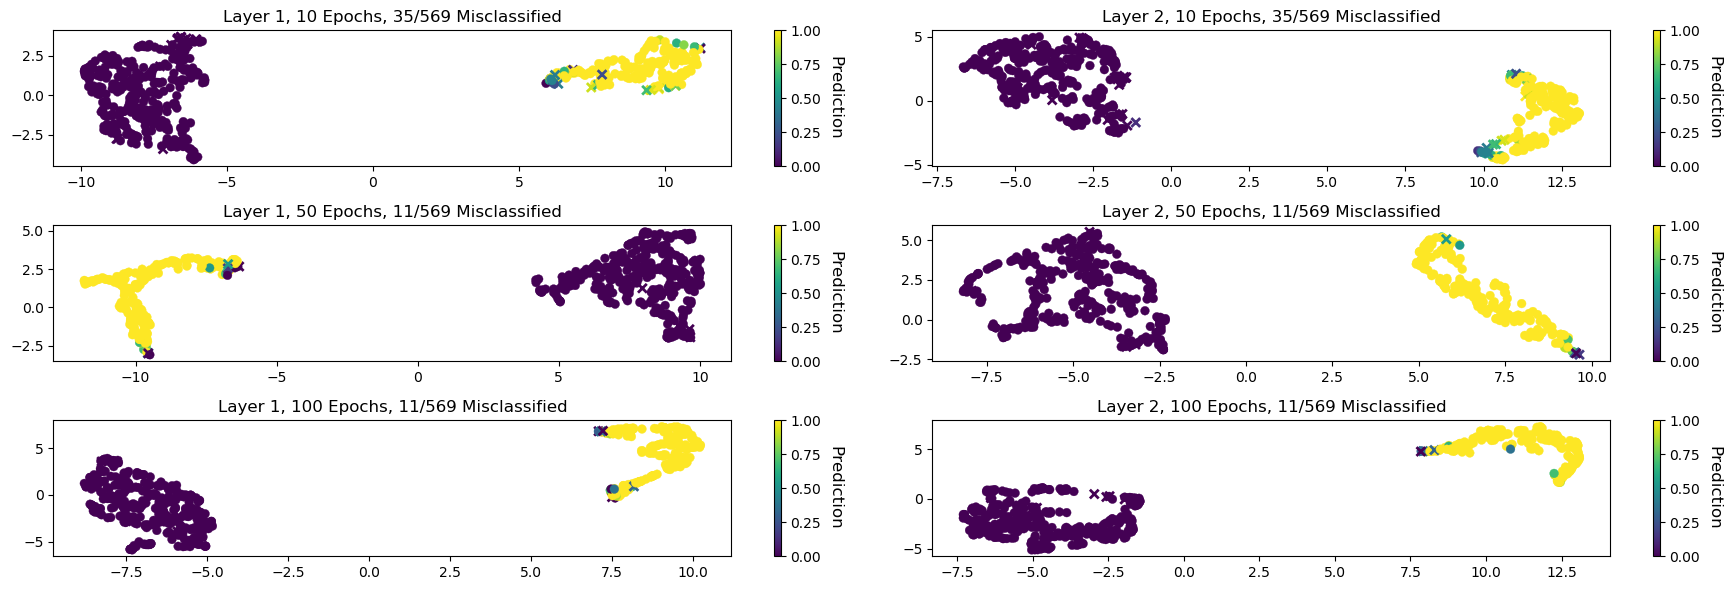

,


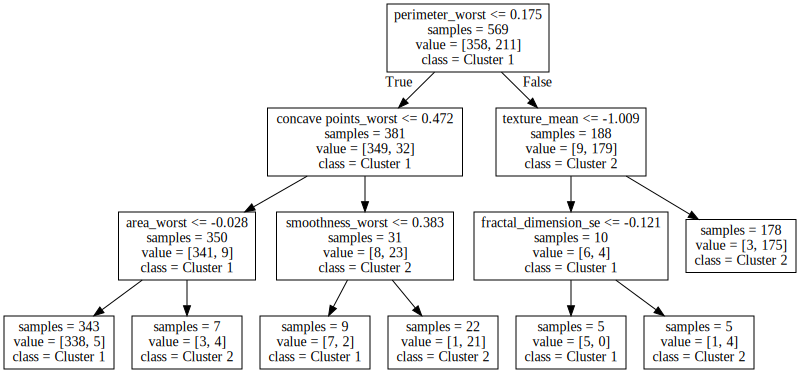

Accuracy Decision Tree:  0.9736379613356766


In [17]:
import warnings
warnings.filterwarnings("ignore")
print("Applying InterVENE to the UCI Breast Cancer Wisconsin (Diagnostic) Data Set, fetched from PMLB (https://github.com/EpistasisLab/penn-ml-benchmarks)")
import random
__counter__ = random.randint(0,2e9)

from sklearn import tree
# %matplotlib qt 
# interactively select subplot
tsneresults = dict()
predictions = dict()
evaluations = dict()
accuracy_table = dict()
nrlayers = 2
figsize = 2
layers = list(range(1,nrlayers))
epochlist = [10, 50,100]
threshold = 0.5

first_image_saved = False
current_tag = ALL
###############################################
# Select points class by LassoSelector
class SubplotSelector(object):
    def __init__(self, plts):
        self.plts = plts
        self.ind = None

class SelectFromCollection(object):
    """Select indices from a matplotlib collection using `LassoSelector`.

    Selected indices are saved in the `ind` attribute. This tool fades out the
    points that are not part of the selection (i.e., reduces their alpha
    values). If your collection has alpha < 1, this tool will permanently
    alter the alpha values.

    Note that this tool selects collection objects based on their *origins*
    (i.e., `offsets`).

    Parameters
    ----------
    ax : :class:`~matplotlib.axes.Axes`
        Axes to interact with.

    collection : :class:`matplotlib.collections.Collection` subclass
        Collection you want to select from.

    alpha_other : 0 <= float <= 1
        To highlight a selection, this tool sets all selected points to an
        alpha value of 1 and non-selected points to `alpha_other`.
    """

    def __init__(self, ax, collection, alpha_other=0.1):
        self.canvas = ax.figure.canvas
        self.collection = collection
        self.alpha_other = alpha_other

        self.xys = collection.get_offsets()
        self.Npts = len(self.xys)

        # Ensure that we have separate colors for each object
        self.fc = collection.get_facecolors()
        self.ec = collection.get_edgecolors()

        if len(self.fc) == 0:
            raise ValueError('Collection must have a facecolor')
        elif len(self.fc) == 1:
            print("facecolors length one")
            self.fc = np.tile(self.fc, (self.Npts, 1))
            self.fcoriginal = np.tile(self.fcoriginal, (self.Npts, 1))

        self.lasso = LassoSelector(ax, onselect=self.onselect)
        self.ind = []
        
    def reset_collection(self, collection):
        self.collection = collection
        self.xys = collection.get_offsets()
        self.fc = collection.get_facecolors()
        self.ec = collection.get_edgecolors()
        if len(self.fc) == 0:
            raise ValueError('Collection must have a facecolor')
        elif len(self.fc) == 1:
            print("facecolors length one")
            self.fc = np.tile(self.fc, (self.Npts, 1))
            self.fcoriginal = np.tile(self.fcoriginal, (self.Npts, 1))
        self.lasso = LassoSelector(ax, onselect=self.onselect)
        self.ind = []
        
    def onselect(self, verts):
#         print("onselect")
        path = Path(verts)
        self.ind = np.nonzero(path.contains_points(self.xys))[0]
        if len(self.ind)>0: #selection made
            self.fc[:, -1] = self.alpha_other
            self.ec[:, -1] = self.alpha_other
            self.fc[self.ind, -1] = 1
            self.ec[self.ind, -1] = 1
            self.collection.set_facecolors(self.fc)
            self.canvas.draw_idle()
        else: #no points selected
            self.fc[:, -1] = 1
            self.ec[:, -1] = 1
            self.collection.set_facecolors(self.fc)
            self.canvas.draw_idle()

    def disconnect(self):
        self.lasso.disconnect_events()
        self.fc[:, -1] = 1
        self.ec[:, -1] = 1
        self.fc[self.ind, -1] = self.alpha_other
        self.ec[self.ind, -1] = self.alpha_other
        self.collection.set_facecolors(self.fc)
        self.canvas.draw_idle()

###############################################
reallabels = list(labels)

cmap = matplotlib.cm.get_cmap('viridis')
e=0
fig1 = plt.figure(figsize=((nrlayers*(figsize+1)*(nrlayers-1)*len(epochlist)),figsize*len(epochlist)))

norm = matplotlib.colors.Normalize()

edgemap = matplotlib.colors.ListedColormap(['darkgrey', 'black'])
plts = []    
for i in epochlist:
    print("Loading plots for network trained for %s epochs..."%str(i))
    model = Model(n_in, n_h1, n_h2, n_out, weight_init, dropout)
    
    model.load_state_dict(torch.load("model_public_%s_%s"%(nrlayers,i)))
    model.eval()
    
    results = model(dataset)

    y_pred = results[-1]

    y_pred = y_pred.detach().numpy().flatten()

    decisions = []
    for p in y_pred:
        if p<=threshold:
            decisions.append(0)
        else:
            decisions.append(1)

    for l in range(nrlayers):

        evaluations[e] = []
        accuracy_table[e] = []
        countmisclass = 0
        for d in range(len(decisions)):
            if decisions[d] == 0 and reallabels[d] == 0:
                evaluations[e].append(1)
                accuracy_table[e].append(TRUE_NEGATIVE)
            elif decisions[d] == 1 and reallabels[d] == 1:
                evaluations[e].append(1)
                accuracy_table[e].append(TRUE_POSITIVE)
            elif decisions[d] == 1 and reallabels[d] == 0:
                evaluations[e].append(0)
                countmisclass +=1
                accuracy_table[e].append(FALSE_POSITIVE)
            elif decisions[d] == 0 and reallabels[d] == 1:
                evaluations[e].append(0)
                countmisclass +=1
                accuracy_table[e].append(FALSE_NEGATIVE)
            else:
                print("Error: should not be possible", decisions[d], reallabels[d])
        
        normed_labels = norm(evaluations[e])

        m=['o' if k==1 else 'x' for k in evaluations[e]]
        np.random.seed(SEED)
        visresults = umap.UMAP(random_state=SEED, transform_seed=SEED, min_dist=0.1, n_neighbors=10, metric='correlation').fit_transform(results[l].detach().numpy())

        xs = visresults[:,0]
        ys = visresults[:,1]
        tsneresults[e]=[xs, ys]
        subp = plt.subplot(len(epochlist), nrlayers, e+1)
        
        subp.set_picker(True)
        plts.append(subp)
        linewidths = [0.25 if k==1 else 2 for k in evaluations[e]]

        sc = mscatter(xs, ys, s= 40, c=y_pred, vmin=0., vmax=1., cmap=cmap, m=m, linewidth=linewidths)
           
        clb = fig1.colorbar(sc)
        predictions[e]=y_pred
        clb.ax.get_yaxis().labelpad = 15
        clb.ax.set_ylabel('Prediction', rotation=270, fontsize=12)
        clb.ax.tick_params(labelsize=10)

        plt.title("Layer %s, %s Epochs, %s/%s Misclassified"%(l+1,i,countmisclass,len(reallabels)))
        
        e+=1
fig1.tight_layout()
plt.savefig('all_visualizations.png', bbox_inches='tight')
subplotselector = SubplotSelector(plts)
pickresults = fig1.canvas.mpl_connect('pick_event', onpick)
plt.show()

###########################